In [2]:
!git clone https://github.com/pytorch/vision.git
!cd vision
!git checkout v0.8.2

Cloning into 'vision'...
remote: Enumerating objects: 660214, done.
remote: Counting objects: 100% (2855/2855), done.
remote: Compressing objects: 100% (1190/1190), done.
remote: Total 660214 (delta 2501), reused 1763 (delta 1652), pack-reused 657359 (from 3)
Receiving objects: 100% (660214/660214), 1.18 GiB | 1003.00 KiB/s, done.
Resolving deltas: 100% (617812/617812), done.
error: pathspec 'v0.8.2' did not match any file(s) known to git


In [3]:
!cp ./vision/references/detection/utils.py ./
!cp ./vision/references/detection/transforms.py ./
!cp ./vision/references/detection/coco_eval.py ./
!cp ./vision/references/detection/engine.py ./
!cp ./vision/references/detection/coco_utils.py ./

In [5]:
!pip install cython
# Install pycocotools, the version by default in Colab
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install -U albumentations
!pip install -U opencv-python


  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-idb0azw_
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-idb0azw_
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'pycocotools' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pycocotools'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for pycocotools: filename=pycocotools-2.0-cp312-cp312-linux_x86_64.whl size=98290 sha256=3c4190a7b2e132d196c3bee68caca14fd30604b239d637403f0fa46e38cf6a3f
  Stored

In [1]:
import os
import numpy as np
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import albumentations as A
import cv2
import time
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from  sklearn.model_selection import KFold
import random

In [7]:
# Create unified training directory
!mkdir -p ./cnn_data/craters/combined_train/images
!mkdir -p ./cnn_data/craters/combined_train/labels

# Copy train images & labels
!cp -a ./cnn_data/craters/train/images/. ./cnn_data/craters/combined_train/images/
!cp -a ./cnn_data/craters/train/labels/. ./cnn_data/craters/combined_train/labels/

# Copy valid images & labels into the same combined folder
!cp -a ./cnn_data/craters/valid/images/. ./cnn_data/craters/combined_train/images/
!cp -a ./cnn_data/craters/valid/labels/. ./cnn_data/craters/combined_train/labels/


In [2]:


class CraterDataset:
    def __init__(self, root, transforms=None):
        """
        Custom Dataset for crater detection using YOLO-format labels.
        Args:
            root (str): Root directory with `images/` and `labels/` subfolders.
            transforms (callable, optional): Albumentations or torchvision-style transforms.
        """
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, "images")))
        self.annots = sorted(os.listdir(os.path.join(root, "labels")))
        self.classes = ['Background', 'Crater']

    def convert_box_cord(self, bboxs, format_from, format_to, img_shape):
        """
        Convert bounding box formats.
        """
        if format_from == 'normxywh' and format_to == 'xyminmax':
            x_center, width = bboxs[:, 1] * img_shape[1], bboxs[:, 3] * img_shape[1]
            y_center, height = bboxs[:, 2] * img_shape[0], bboxs[:, 4] * img_shape[0]
            xmin = x_center - width / 2
            xmax = x_center + width / 2
            ymin = y_center - height / 2
            ymax = y_center + height / 2
            return np.stack((xmin, ymin, xmax, ymax), axis=1)
        else:
            raise NotImplementedError(f"Conversion from {format_from} to {format_to} is not implemented")

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "labels", self.annots[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        # Load annotation
        if os.path.getsize(annot_path) > 0:
            bboxs = np.loadtxt(annot_path, ndmin=2)
            bboxs = self.convert_box_cord(bboxs, 'normxywh', 'xyminmax', img.shape)
            num_objs = bboxs.shape[0]
            labels = torch.ones((num_objs,), dtype=torch.int64)
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        else:
            bboxs = np.array([[0, 0, img.shape[1], img.shape[0]]], dtype=np.float32)
            labels = torch.zeros((1,), dtype=torch.int64)
            iscrowd = torch.zeros((1,), dtype=torch.int64)

        bboxs = torch.as_tensor(bboxs, dtype=torch.float32)
        area = (bboxs[:, 2] - bboxs[:, 0]) * (bboxs[:, 3] - bboxs[:, 1])
        image_id = torch.tensor([idx])

        target = {
            "boxes": bboxs,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        # Apply transforms (Albumentations style expected)
        if self.transforms:
            transformed = self.transforms(image=img, bboxes=target["boxes"].numpy(), labels=labels.numpy())
            img = transformed["image"]
            target["boxes"] = torch.tensor(transformed["bboxes"], dtype=torch.float32)
            target["labels"] = torch.tensor(transformed["labels"], dtype=torch.int64)

        # Handle empty boxes post-transform
        if target["boxes"].ndim != 2 or target["boxes"].numel() == 0:
            target["boxes"] = torch.tensor([[0, 0, img.shape[1], img.shape[0]]], dtype=torch.float32)
            target["labels"] = torch.zeros((1,), dtype=torch.int64)

        return img, target

    def __len__(self):
        return len(self.imgs)


In [3]:
def get_model_bbox(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [4]:
def get_transform(train):
    if train:
        return A.Compose([
            # A.Flip(p=0.5),
            # A.RandomResizedCrop(height=640,width=640,p=0.4),
            # # A.Perspective(p=0.4),
            # A.Rotate(p=0.5),
            # # A.Transpose(p=0.3),
            ToTensorV2(p=1.0)],
            bbox_params=A.BboxParams(format='pascal_voc',min_visibility=0.4, label_fields=['labels']))
    else:
        return A.Compose([ToTensorV2(p=1.0)],
                         bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.5, label_fields=['labels']))

In [5]:

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    a.imshow(img.permute((1,2,0)))
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 edgecolor='b',
                                 facecolor='none',
                                 clip_on=False)
        a.annotate('Crater', (x,y-20), color='blue', weight='bold',
                   fontsize=10, ha='left', va='top')

        a.add_patch(rect)
    plt.show()

/home/praneeth-yeddu/crater_detection/env/lib/python3.12/site-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


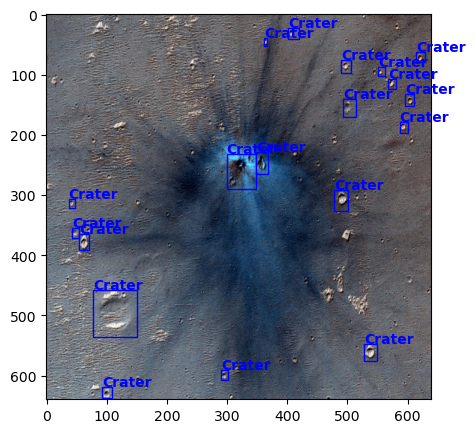

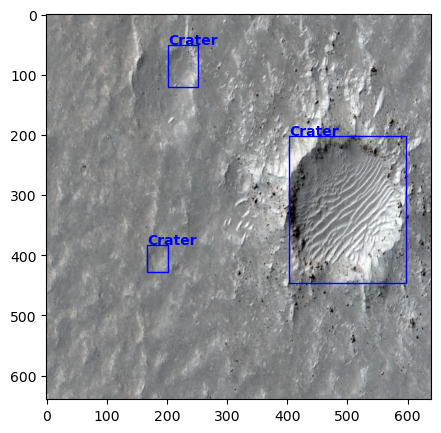

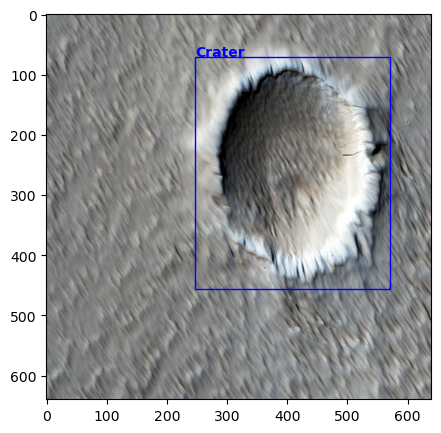

In [6]:
dataset = CraterDataset('cnn_data/craters/combined_train', get_transform(train=True))
# Prints an example of image with annotations
for i in random.sample(range(1, 100), 3):
    img, target = dataset[i]
    plot_img_bbox(img, target)

In [7]:
device = torch.device('cpu') 
k_folds = 5
num_epochs = 25

num_classes = 2
# use our dataset and defined transformations
dataset = CraterDataset('cnn_data/craters/combined_train', get_transform(train=True))
dataset_val = CraterDataset('cnn_data/craters/combined_train', get_transform(train=False))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    dataset_subset = torch.utils.data.Subset(dataset, list(train_ids))
    dataset_val_subset = torch.utils.data.Subset(dataset_val, list(val_ids))

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
            dataset_subset, batch_size=8, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val_subset, batch_size=1, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_bbox(num_classes)
    

    
  
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,  # Check if beneficial
                                momentum=0.9, weight_decay=0)

    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=10,
                                                    gamma=0.1)
    
    # let's train!
    for epoch in range(num_epochs):


        # train for one epoch, printing every 50 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
    evaluate(model, data_loader_val, device=device)

--------------------------------
FOLD 0
--------------------------------


/home/praneeth-yeddu/crater_detection/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/praneeth-yeddu/crater_detection/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/praneeth-yeddu/crater_detection/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/13]  eta: 0:06:21  lr: 0.000421  loss: 1.1353 (1.1353)  loss_classifier: 0.7518 (0.7518)  loss_box_reg: 0.2356 (0.2356)  loss_objectness: 0.1336 (0.1336)  loss_rpn_box_reg: 0.0143 (0.0143)  time: 29.3655  data: 1.4489  max mem: 0


KeyboardInterrupt: 